## Goal: Visualize and Understand different optimizers in Deep learning

Let's recap our recipe for machine learning
## 3 Step Recipe
- Fix a representation (neural networks, parameterized by weights $\theta$)
- Define a measure of goodness $\rightarrow$Loss Function $L(\theta)$
- Choose an optimization strategy (gradient descent)

Gradient Descent:
- $L(\theta)$
- $g_t \leftarrow \nabla_{\theta} L(\theta_{t-1})$
- $\theta_{t} \leftarrow \theta_{t-1} - \lambda g_t$

## Visualizing Different Optimizers
- Gradient Descent
- Newton's Method (second-order derivative)
- Momentum
- ADAM

h/t to [Recitation 3 of CMU 11-785](http://deeplearning.cs.cmu.edu/F20/index.html), this [fantastic Distill.pub article](https://distill.pub/2017/momentum/), and the [Deep Learning Notes from this course](https://chinmayhegde.github.io/dl-notes/notes/lecture03/#variants-of-sgd-momentum-rmsprop-and-adam).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import torch

%matplotlib inline

We will try to visualize running gradient descent (and its variants) on a simple quadratic function in two variables: 
## $$f(x,y) = ax^2 + by^2 + cxy + dx + ey$$

By setting the constants differently, the above function represents all conic surfaces -- paraboloids, hyperboloids, ellipsoids, etc. Let's see how to optimize these functions. We will be plotting these functions in 2 dimensions within this notebook but feel free to check them out in 3D here: https://www.math3d.org/


This is the mapping we can keep in mind:

$$ \text{deep learning} \leftrightarrow \text{this notebook}$$ 
$$ \text{Trainable Params }\theta \leftrightarrow \text{Trainable Params }(x,y)$$
$$L(\theta)\leftrightarrow f(x,y)$$
$$ \text{initialize } \theta_0 \leftrightarrow \text{initialize } (x_0,y_0)$$
$$\text{minimize }L \leftrightarrow \text{minimize } f$$

In [9]:
class QuadFunc:
    def __init__(self, a, b, c, d, e):
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.e = e

    def getParams(self, x, y):
        if y is None:
            y = x[1]
            x = x[0]
        return x,y

# defining our function
    def __call__(self, x, y=None):
        x,y = self.getParams(x,y)
        return 0.5 * (self.a*x**2 + self.b*y**2) + self.c * x * y + self.d * x + self.e * y

    def grad(self, x, y=None):
    #df/dx = ax + cy + d
    #df/dy = by + cx + e
        x,y = self.getParams(x,y)
        return torch.tensor([self.a * x + self.c * y + self.d, self.b * y + self.c * x + self.e])

# The Hessian Matrix (multivariant function in the form of a matrix)
# https://www.khanacademy.org/math/multivariable-calculus/applications-of-multivariable-derivatives/quadratic-approximations/a/the-hessian
    def hess(self, x, y=None):
    #d2f/dx2 = a
    #d2f/dy2 = b
    #d2f/dxdy = c
    #d2f/dydx = c
        x, y = self.getParams(x,y)
        return torch.tensor([[self.a, self.c], [self.c, self.b]])


class GradientDescent:
    def __init__(self, lr=1, b1=0.9, b2=0.999):
        # b1 -> Momentum
        # b2 -> ADAM
        # ADAM Paper -> https://arxiv.org/abs/1412.6980
        self.lr = lr # learning rate
        self.b1 = b1 # grad aggregation param (for Momentum)
        self.b2 = b2 # grad^2 aggregation param (for ADAM)
        
        self.v = 0 # grad aggregation param
        self.w = 0 # grad^2 aggregation param
        self.t = 0
        
        self.eps = 1e-9
        
    def __call__(self, grad,hess):
        
        self.t += 1


        # aggregation
        self.v = self.b1*self.v + (1-self.b1)*grad
        self.w = self.b2*self.w + (1-self.b2)*grad**2
        
        # bias correction
        vcorr = self.v/(1-self.b1**self.t)
        wcorr = self.w/(1-self.b2**self.t) if self.b2 != 0 else 1
        
        # The negative acts the way we want in gradient descent
        return -1*self.lr*vcorr/(wcorr**0.5 + self.eps)
    
class Newtons:
    # https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization
    def __init__(self, lr=1):
        self.lr = lr
        
    def __call__(self,grad,hess):
        return -1*self.lr*torch.matmul(torch.inverse(hess), grad)
    
def runOptim(init,optim,func,steps):
    
    curpos = init # current position
    path = [curpos]

    
    for _ in range(steps):        

        grad = func.grad(curpos)
        hess = func.hess(curpos)
            
        dx = optim(grad,hess)
        curpos = curpos + dx
        path.append(curpos)
    
    return path

# shows where the optimizations start and where they ends
def showPath(func,init,paths,labels,colors,levels):

    x = torch.arange(-10,10,0.05)
    y = torch.arange(-10,10,0.05)
    
    # create meshgrid
    xx, yy = torch.meshgrid(x,y)
    zz = func(xx,yy)
    
    # create contour
    fig, ax = plt.subplots(1,1,figsize=(16,10))
    cp = ax.contourf(xx,yy,zz,levels)
    fig.colorbar(cp)
    
    # mark initial point
    ax.plot(init[0],init[1],'ro')
    ax.text(init[0]+0.5,init[1]+0.5,'Intial Point',color='white')
    
    # Plot paths
    for pnum in range(len(paths)):
        for i in range(len(paths[pnum])-1):
            curpos = paths[pnum][i]
            d = paths[pnum][i+1] - curpos
            ax.arrow(curpos[0],curpos[1],d[0],d[1],color=colors[pnum],head_width=0.2)
            ax.text(curpos[0]+d[0],curpos[1]+d[1],str(i),color='white')
    
    # Add legend
    legends = []
    for col in colors:
        legends.append(mpatches.Patch(color=col))
    ax.legend(legends,labels)
  

## Gradient Descent

## $f(x,y) = x^2 + y^2$

Here, the function is convex, the "valley" has a unique global minimum, and optimization is straightforward.

/Users/apple/opt/anaconda3/envs/tf/lib/python3.7/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_2a19nf9hj1/croot/pytorch_1675190251927/work/aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


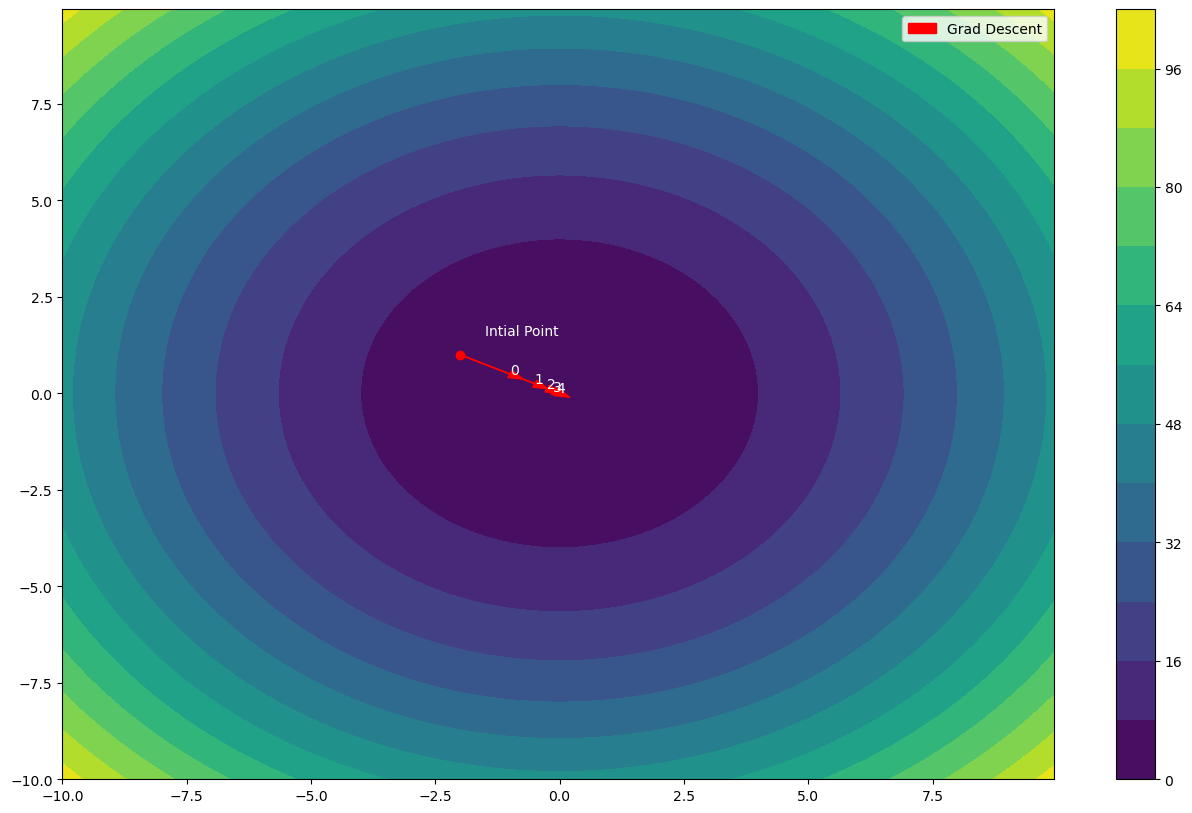

In [10]:
f = QuadFunc(a=1.0, b=1.0, c=0., d=0., e=0.)
init = torch.tensor([-2.0, 1.0])
regGD = GradientDescent(lr = 0.5, b1=0, b2=0) # turned off Momentum and ADAM
steps = 5
path = runOptim(init, regGD, f, steps)
showPath(f, init, [path], ['Grad Descent'], ['r'], levels=15)

Unfortunately, in deep learning we tend to not optimize such simple convex functions. Let's see what happens if we apply gradient descent to non-convex functions. 
## $f(x,y) = x^2 - y^2$

Check that the path of gradient descent is very much dependent on how we choose the initialization. For example, change the `init` value to be (-2.0,0.0) and see what happens.

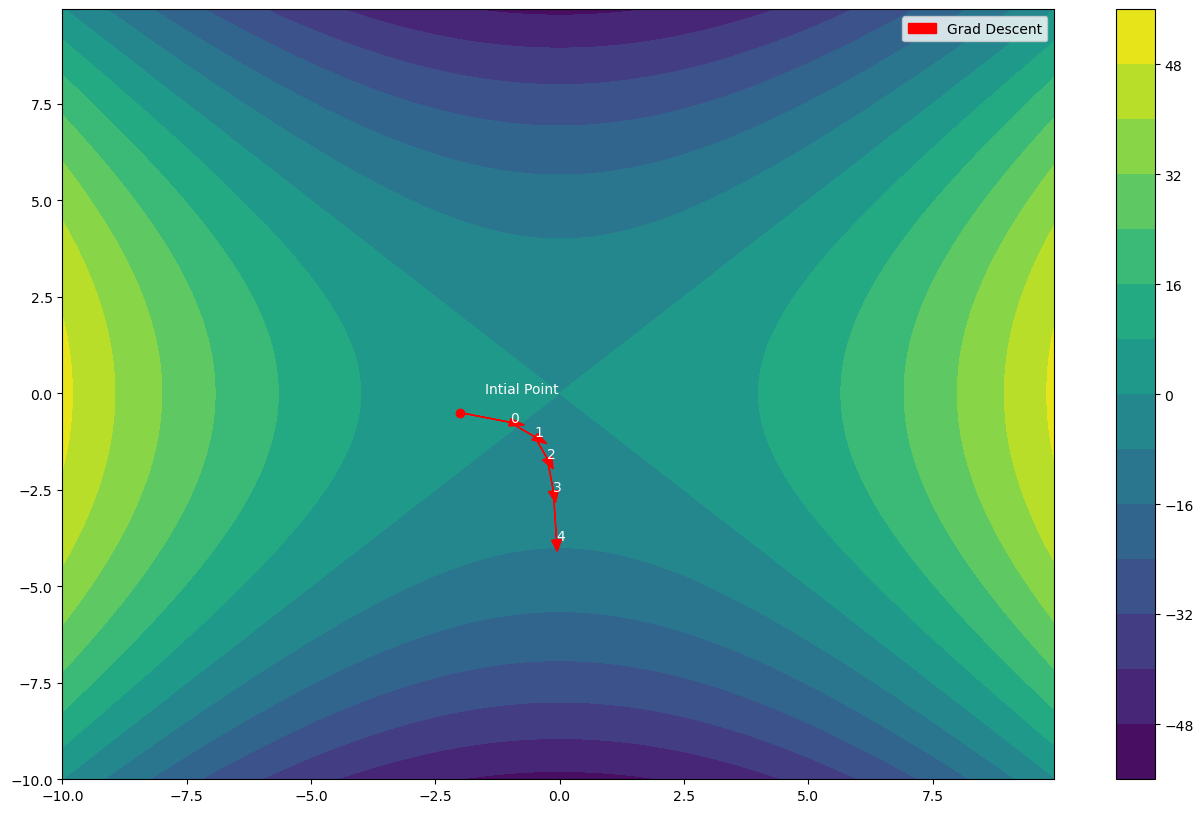

In [12]:
f = QuadFunc(a=1.0, b=-1.0, c=0., d=0., e=0.)
init = torch.tensor([-2.0, -0.5])
regGD = GradientDescent(lr = 0.5, b1=0, b2=0) # turned off Momentum and ADAM
steps = 5
path = runOptim(init, regGD, f, steps)
showPath(f, init, [path], ['Grad Descent'], ['r'], levels=15)

In fact, there is a more insiduous issue with gradient descent. Let's go back to the convex case (where everything is supposed to work). Choose a parabolic function where the level set contours are skewed ellipses: 
## $f(x,y) = x^2 + y^2 - 0.8xy + x + y$

In such cases, gradient descent (which just follows the locally steepest direction) tends to oscillate quite a bit.

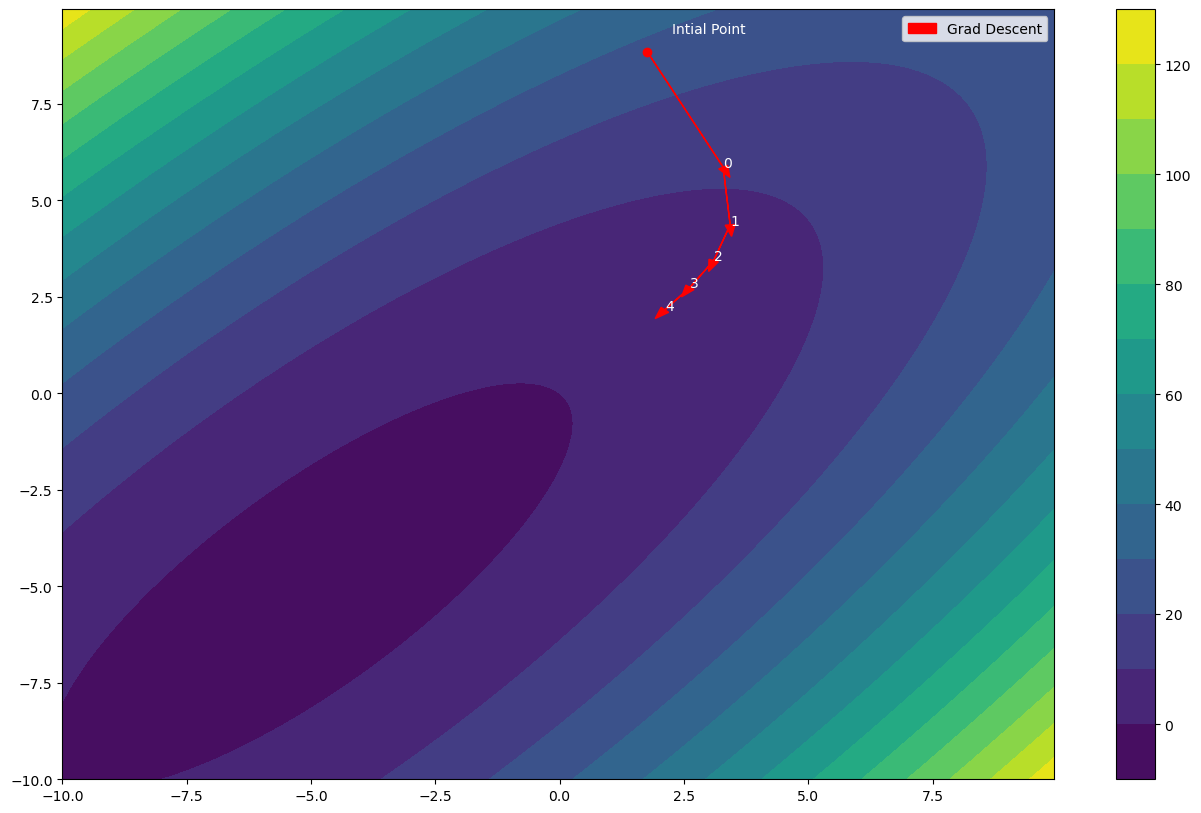

In [15]:
a = 1/torch.sqrt(torch.tensor(2.0))
ell = QuadFunc(a,a,-0.8*a,a,a)

init = torch.matmul(torch.tensor([[a,a],[-a,a]]),torch.tensor([-5.0,7.5]))
steps = 5 
regGD = GradientDescent(lr=0.5, b1=0, b2=0)
path = runOptim(init, regGD, ell, steps)
showPath(ell, init, [path], ['Grad Descent'], ['r'], 15)

## Gradient Descent Takeaways
- Depends upon initializaiton
- Follows the direction of steepest descent

One way to fix this is via Newton's method (which scales different gradient directions according to the second derivative, or the Hessian). This has the effect of "unskewing" the loss surface, making it look more like the parabola, and therefore enables easier optimization.

## Netwon's Method

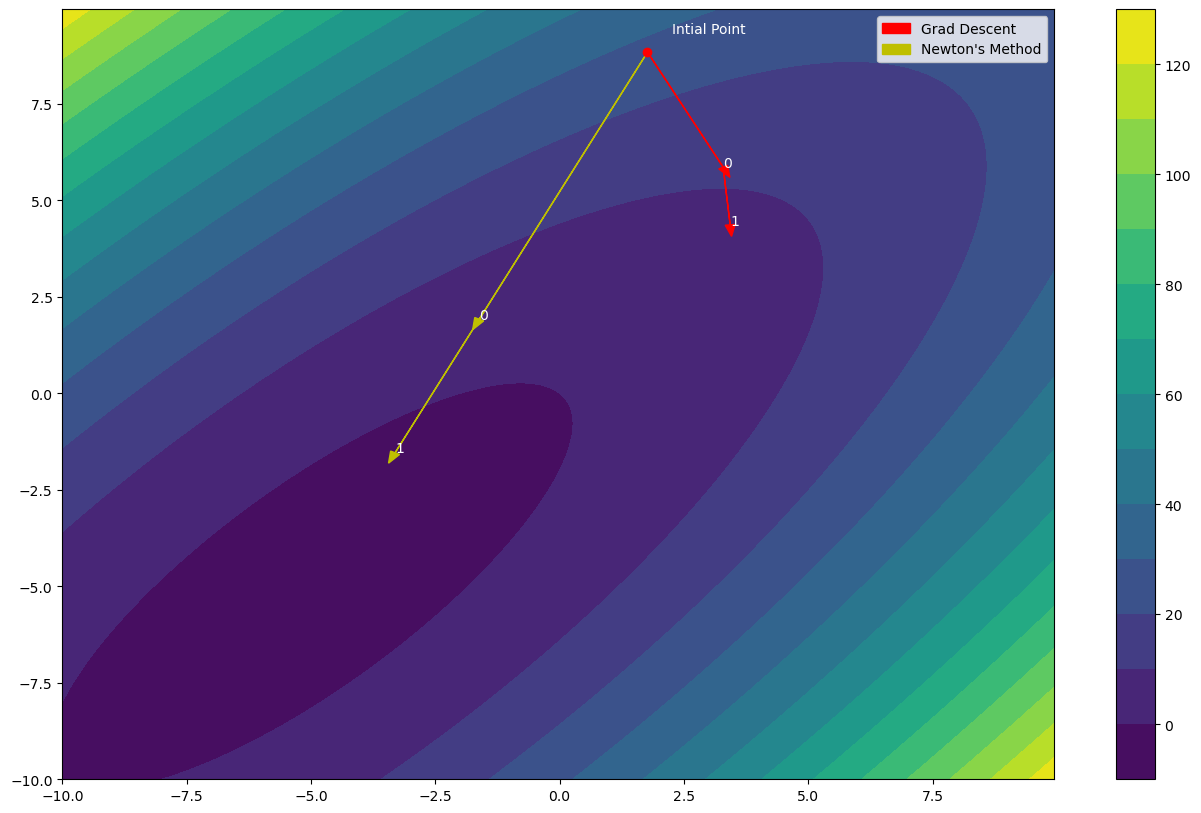

In [16]:
# we get more direct path towards the minimum value without so many iteration 
a = 1/torch.sqrt(torch.tensor(2.0))
ell = QuadFunc(a,a,-0.8*a,a,a)

init = torch.matmul(torch.tensor([[a,a],[-a,a]]),torch.tensor([-5.0,7.5]))
steps = 2 
regGD = GradientDescent(lr=0.5, b1=0, b2=0)
newMT = Newtons(lr=0.5)
path = runOptim(init, regGD, ell, steps)
path2 = runOptim(init, newMT, ell, steps)
showPath(ell, init, [path, path2], ['Grad Descent', 'Newton\'s Method'], ['r', 'y'], 15)

Unfortunately, Newton's method is difficult to use in deep learning since Hessians are very difficult to compute if the number of parameters become large. Also, somewhat curiously, Newton's method tends to get attracted to saddle points. Let's revisit the saddle example.

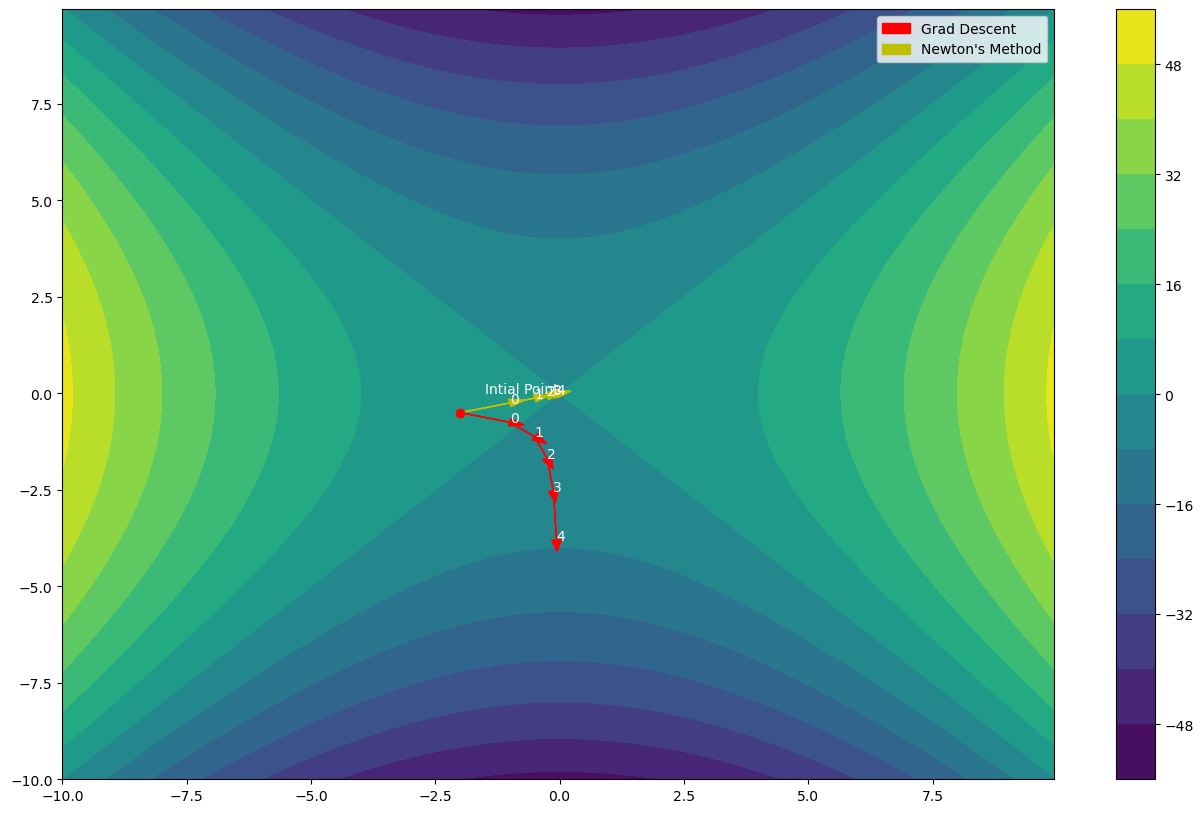

In [17]:
f = QuadFunc(a=1.0, b=-1.0, c=0., d=0., e=0.)
init = torch.tensor([-2.0, -0.5])
regGD = GradientDescent(lr = 0.5, b1=0, b2=0) # turned off Momentum and ADAM
newMT = Newtons(lr=0.5)
steps = 5
path = runOptim(init, regGD, f, steps)
path2 = runOptim(init, newMT, f, steps)
showPath(f, init, [path, path2], ['Grad Descent', 'Newton\'s Method'], ['r', 'y'], levels=15)

## Newton's Method Takeaways
- Calculate second order derivatives
- Attracted to Saddle Points

## [Momentum](https://chinmayhegde.github.io/dl-notes/notes/lecture03/#momentum)

Momentum is a way to simulate the effects of Newton's method without looking at second order information. It adds a "damping" effect on the oscillations (so that the trajectories are typically smoother than standard GD). Let's first write out the algorithm for SGD with Momentum.

- $L(\theta)$
- $g_t \leftarrow \nabla_{\theta} L(\theta_{t-1})$
- $v_t \leftarrow b_1 v_{t-1}+ \lambda g_t$
- $\theta_{t} \leftarrow \theta_{t-1} - v_t$

Observe that we now have an intermediate variable $v_t$ that keeps a "memory" of the previous gradients. Let's see its effects in the ellipse example.

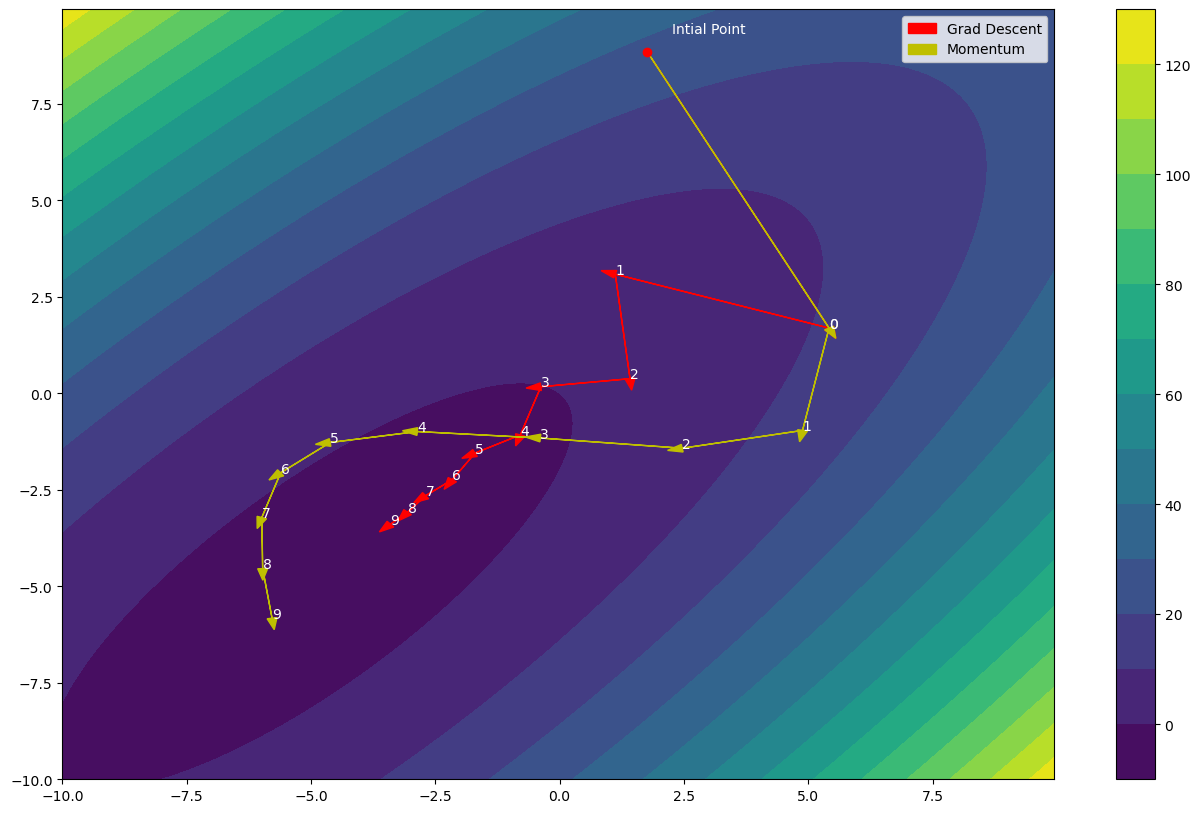

In [18]:
a = 1/torch.sqrt(torch.tensor(2.0))
init = torch.matmul(torch.tensor([[a,a],[-a,a]]),torch.tensor([-5.0,7.5]))
ell = QuadFunc(a,a,-0.8*a,a,a)
steps = 10
lr = 1.2  
regGD = GradientDescent(lr,0,0) # Without Momentum
momGD = GradientDescent(lr,0.9,0) # Momentum
path1 = runOptim(init,regGD,ell,steps)
path2 = runOptim(init,momGD,ell,steps)
showPath(ell,init,[path1,path2],['Grad Descent','Momentum'],['r','y'], 15)

Given our value of $b_1$ above, we can "unroll" $v_t$:

$v_t \leftarrow \lambda g_t + 0.9 \lambda g_{t-1} + 0.81 \lambda g_{t-2} + 0.73\lambda g_{t-3} + \cdots + $

So our $v_t$ term places less importance on gradients calculated many timesteps ago and places more importance on recently computed gradients.

## Momentum Takeaways
- Smoother Trajetory
- Choice of learning rate still matters

## [ADAM](https://chinmayhegde.github.io/dl-notes/notes/lecture03/#adam)
As we can see, momentum speeds up gradient descent but there's still the issue of tuning the learning rate property.

ADAM takes care of this by automatically tuning the learning rate ("adaptive scheduling").

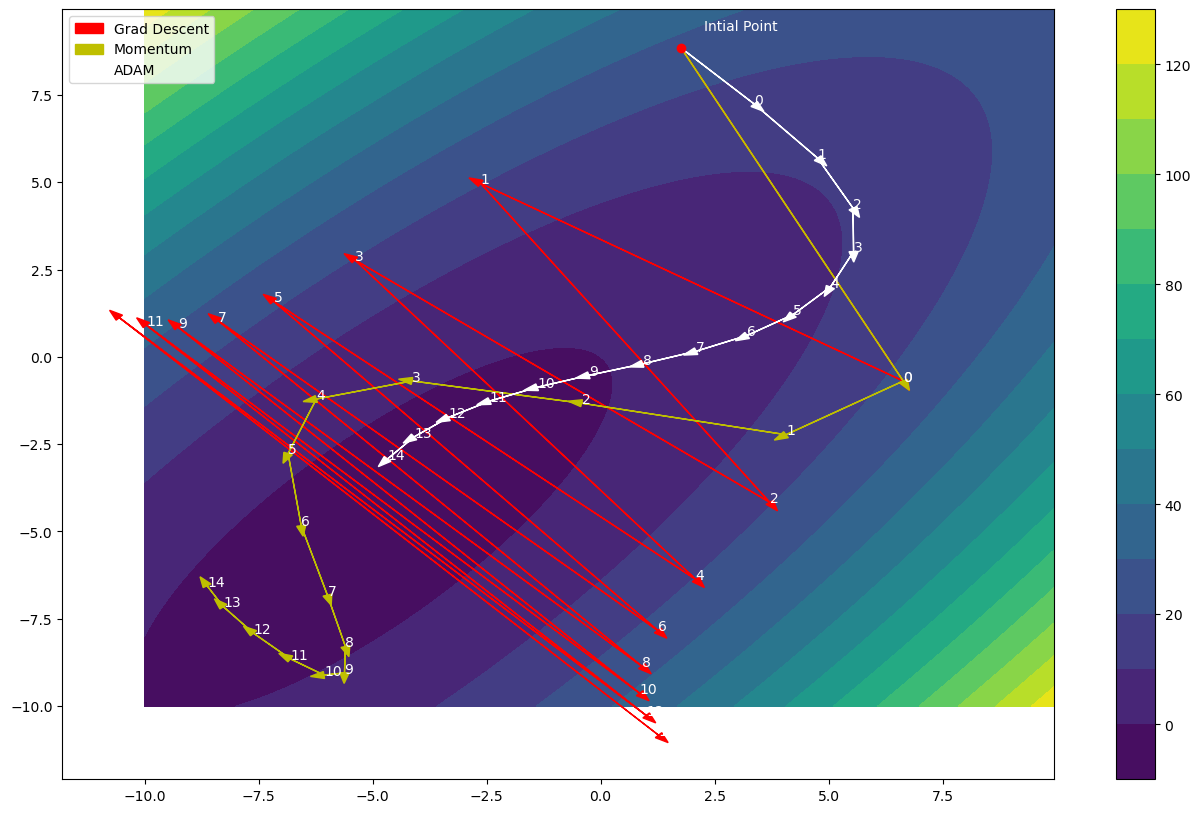

In [19]:
a = 1/torch.sqrt(torch.tensor(2.0))
init = torch.matmul(torch.tensor([[a,a],[-a,a]]),torch.tensor([-5.0,7.5]))
ell = QuadFunc(a,a,-0.8*a,a,a)
steps = 15
lr = 1.6
# High learning rate
regGD = GradientDescent(lr,0,0)
momGD = GradientDescent(lr,0.9,0)
adamGD = GradientDescent(lr,0.9,0.999)
path1 = runOptim(init,regGD,ell,steps)
path2 = runOptim(init,momGD,ell,steps)
path3 = runOptim(init,adamGD,ell,steps)
showPath(ell,init,[path1,path2,path3],['Grad Descent','Momentum','ADAM'],['r','y','w'], 15)

That's it! Feel free to play around with various parameters -- different optimizers, different learning rates, damping factors, etc.

Onto the big question: which optimizer should be used?

Unfortunately there is no clear answer. The choice of "best" optimizer seems to be model-dependent. A general couple of thumb rules:

    For vision applications involving ResNets, SGD + momentum seems to be sufficient.
    for NLP applications and transformer architectures, ADAM seems to work really well.

In practice, it may be useful to play around with different optimizers and perform some basic hyperparameter tuning depending on your specific problem.

Also, take a look at [Torch's implementation of SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html). You can see how they implement momentum!